In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## Helper Functions

In [2]:
def cvplot(img):
    plt.imshow(img, interpolation = 'bicubic')
    plt.show()

## Main

Reading in and pre-processing the image.

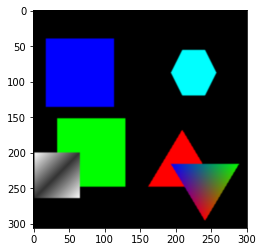

In [3]:
# Reading in and converting image to grayscale
img = cv.imread('image.png')
g_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#Removing noise usign a Gaussian filter
blur = cv.GaussianBlur(g_img, (5, 5), 0)

#Thresholding the image for edge detection and hence contour detection
t,binary = cv.threshold(g_img,0,255,cv.THRESH_BINARY)
cvplot(img)

Let's take a look at the grayscale image.

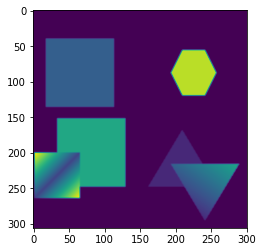

In [4]:
cvplot(g_img)

Number of contours =  4


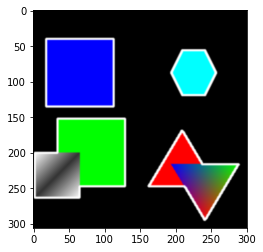

In [5]:
#Finding contours using cv2 function
image, contours, hierarchy = cv.findContours(binary,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
l = len(contours)
print("Number of contours = ",l)
#Drawing contour lines on the original colored image
cv.drawContours(img, contours, -1, (255,255,255), 2)
cvplot(img)

Finding the number of pixels inside (area) of each contour and intensities of the pixels inside. The minimum and maximum values of the pixel intensities of each contour is calculated from the cv2 function as well using mask image method.

In [6]:
lst_intensities = []
m2_area = [] # Method 2 area
m1_lst =[]
m2_lst =[]
min_locs =[]
max_locs =[]
sum_intensities  =[]
hists =[]
dcs =[]

for i in range(l):
    # Create a mask image that contains the contour filled with 0 intensity pixels
    mimg = np.zeros_like(g_img)
    b_img = cv.drawContours(mimg, contours, i, color=255, thickness=-1)
    
    # Access the pixels inside the contour by finding where the pixels with the values 255 exist
    pts = np.where(mimg == 255)
    c_img = g_img[pts[0], pts[1]]
    
    # Finding histograms of each contour
    hists.append(cv.calcHist([c_img],[0],None,[256],[0,256]))
    
    # Dictionary with number of pixels vs. intensity
    dct =  dict(zip(range(0,256),np.zeros(256)))
    for pxl in c_img:
        dct[pxl]+=1
        
    dcs.append(dct)   
    
    # Finding area of the contours by finding the number of pixels in the contour
    m2_area.append(len(pts[0]))
    
    # Finding the intensities and sum of the intensities of the pixels
    lst_intensities.append(c_img)
    sum_intensities.append(np.sum(lst_intensities[i]))
    
    #Finding the min and max value of intensities and their locations 
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(c_img) # Finding min and max intensity using cv2 function
    m1_lst.append((min_val,max_val)) 
    m2_lst.append((np.amin(lst_intensities[i]),np.amax(lst_intensities[i])))# Finding min intensity using mask method
    min_locs.append(min_loc)
    max_locs.append(max_loc)

Calculating number of pixels in each contour and center of gravity/mass from moments function. The number of pixels in each contour is equal to the area of the contour. 

In [7]:
m1_area =[] # Method 1 area
cent_mass =[]
for i in range(l):
    M = cv.moments(contours[i])
    m1_area.append(M['m00']) # Area calculated by the moments function
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cent_mass.append([cx,cy])
    print("The center of gravity of contour number "+str(i)+" =",cent_mass[i])

The center of gravity of contour number 0 = [225, 231]
The center of gravity of contour number 1 = [69, 207]
The center of gravity of contour number 2 = [225, 87]
The center of gravity of contour number 3 = [65, 87]


Plotting the center of mass of each contour in the orginal image.


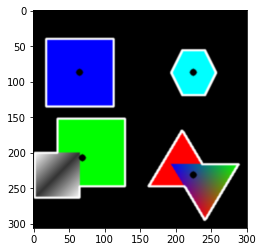

In [8]:
for i in range(l):
    cv.circle(img, tuple(cent_mass[i]),2,(0,0,0), thickness=5, lineType=8, shift=0)
#     cv.putText(img, str(i), tuple(cent_mass[i]), 1, 1, (255, 255, 255), 2, cv.LINE_AA)
cvplot(img)

Cheking if the min and max values found by the two methods are the same.

In [9]:
print("List of min and max intensities found by cv2 function = ", m1_lst)
print("List of min and max intensities found by mask image method = ", m2_lst)

List of min and max intensities found by cv2 function =  [(29.0, 149.0), (51.0, 252.0), (226.0, 226.0), (76.0, 76.0)]
List of min and max intensities found by mask image method =  [(29, 149), (51, 252), (226, 226), (76, 76)]


Checking if the areas found by the two methods are the same.

In [10]:
diff = [m2_area[i]-m1_area[i]for i in range(l)]
print("Areas found by moments = ",m1_area)
print("Areas found by mask image method = ",m2_area)
print("Difference in areas calculated by the two methods = ",diff)

Areas found by moments =  [6068.5, 11538.0, 2977.0, 9025.0]
Areas found by mask image method =  [6246, 11776, 3072, 9216]
Difference in areas calculated by the two methods =  [177.5, 238.0, 95.0, 191.0]


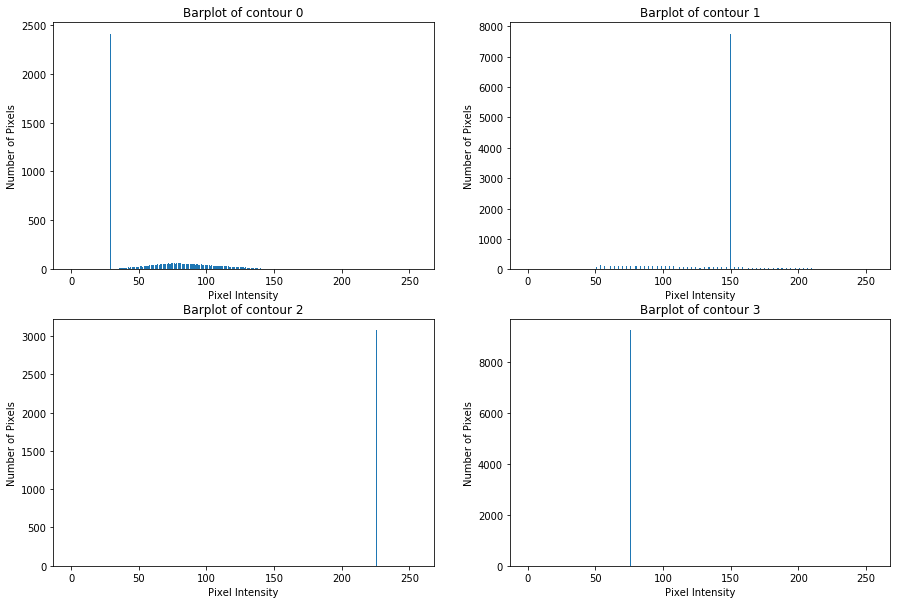

In [11]:
fig, axs = plt.subplots(2,int(l/2), figsize=(15, 10))
axs = axs.ravel()

for i in range(l):
    d =dcs[i]
    axs[i].bar(range(len(d)), d.values(), align='center')
    axs[i].set_title("Barplot of contour "+ str(i))
    axs[i].set_xlabel("Pixel Intensity")
    axs[i].set_ylabel("Number of Pixels")    
plt.show()

Plotting the number of pixels vs. intensity using cv2  histogram function, for comparison.

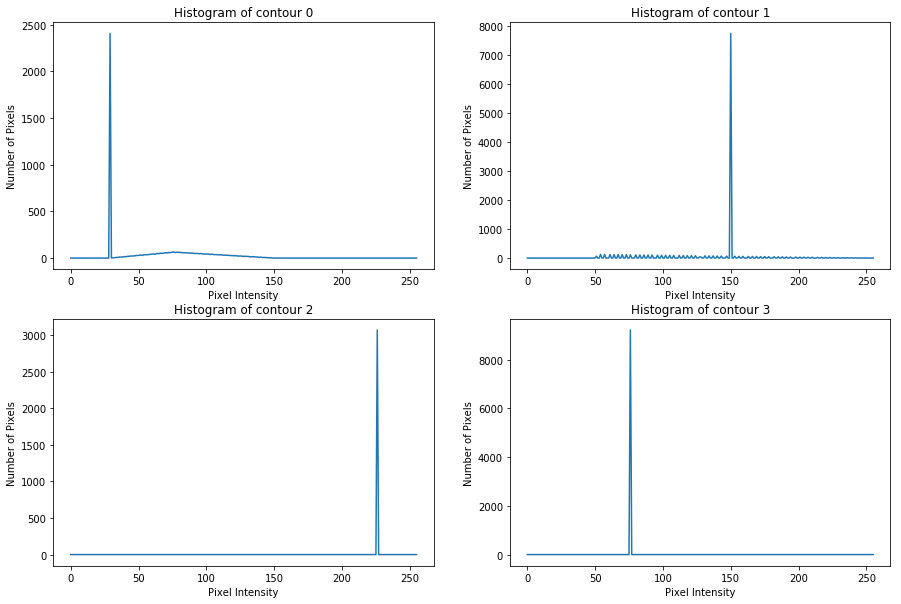

In [12]:
fig, axs = plt.subplots(2,int(l/2), figsize=(15, 10))
axs = axs.ravel()

for i in range(l):
    axs[i].plot(hists[i])
    axs[i].set_title("Histogram of contour "+ str(i))
    axs[i].set_xlabel("Pixel Intensity")
    axs[i].set_ylabel("Number of Pixels")    
plt.show()